In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from node2vec import Node2Vec
from ete3 import ClusterTree
from ete3 import Tree
import dendropy
import pprint
import skbio
from skbio import TreeNode
from io import StringIO
from ete3 import Tree
from phylodm import PhyloDM
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa    
from scipy.spatial import procrustes
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac

### Integrating Phylogeny with Abundance Data

**Objective:**
This notebook aims to explore and compare different methods for integrating phylogenetic information into abundance data.

**Methods Compared:**

1. **Simple Matrix Multiplication:**  
   Direct multiplication of the `Abundance_Matrix` with the `Phylogeny_Matrix` using `Abundance_Matrix @ Phylogeny_Matrix`.

2. **MDS Transformation:**  
   Multiplying the `Abundance_Matrix` with the `MDS(Phylogeny_Matrix)` where MDS refers to Multi-Dimensional Scaling applied to the `Phylogeny_Matrix`.

3. **Isomap Transformation:**  
   Multiplying the `Abundance_Matrix` with the `Isomap(Phylogeny_Matrix)` where Isomap is applied to the `Phylogeny_Matrix`.

4. **PCA Transformation:**  
   Multiplying the `Abundance_Matrix` with the `PCA(Phylogeny_Matrix)` where Principal Component Analysis (PCA) is applied to the `Phylogeny_Matrix`.

**Evaluation:**
The resulting matrices from the above methods are compared against a UniFrac distance matrix derived from the same dataset. The comparison involves several techniques:
- **Principal Coordinates Analysis (PCoA)**
- **Procrustes Analysis**
- **K-Medoids Clustering**

The goal is to determine whether the incorporation of phylogenetic information enhances the grouping of subjects with similar phylogenetic backgrounds in the ordination space.

In [88]:
%cd /home/zkarwowska/phylogeny_VAE/

/home/zkarwowska/phylogeny_VAE


In [89]:
pathways = pd.read_csv('inputs/pathways.csv', index_col= [0], low_memory=False).iloc[:, 2:].sort_index()

taxonomy = pd.read_csv('inputs/taxonomy.csv', index_col= [0], low_memory=False).fillna(0).sort_index()
taxonomy_relab = taxonomy.div(taxonomy.sum(axis=1), axis=0).dropna()
taxonomy_binary = taxonomy.astype(bool).astype(int)

metadata = pd.read_csv('inputs/metadata.csv', index_col= [0], low_memory=False).sort_index()
metadata = metadata[metadata['sample_id'].isin(taxonomy.index)]

In [90]:
pathways.shape, taxonomy.shape, metadata.shape

((15346, 575), (15346, 942), (15346, 141))

In [91]:
## Read tree and filter only 
nwk = 'inputs/phylogenetic_tree.nwk'

ete3_tree = Tree(nwk)
otu_ids = taxonomy.columns.tolist()
ete3_tree.prune(otu_ids, True)
ete3_tree.write(outfile="inputs/pruned_skbio_tree.nwk", format=1)


# Get array from phyogenetic tree
pdm = PhyloDM.load_from_newick_path('inputs/pruned_skbio_tree.nwk')
dm = pdm.dm(norm=True)
labels = pdm.taxa()

In [92]:
nwk = 'inputs/phylogenetic_tree.nwk'

ete3_tree = Tree(nwk)
skbio_tree = TreeNode.read(nwk, 'newick')
leaf_names = ete3_tree.get_leaf_names()

otu_ids = taxonomy.columns.tolist()

#prune tree to only bacteria present in counts table
ete3_tree.prune(otu_ids, True)
pruned_skbio_tree = TreeNode.read(StringIO(ete3_tree.write(format=1, format_root_node=True)))

def replace_spaces_in_names_skbio(node):
    # Replace spaces with double underscores in the current node's name if it has one
    if node.name:
        node.name = node.name.replace(' ', '_')
    # Recursively apply this to all children
    for child in node.children:
        replace_spaces_in_names_skbio(child)

# Apply the function to your tree
replace_spaces_in_names_skbio(pruned_skbio_tree)

## Unifrac dm

In [93]:
def get_unweighted_unifrac_dm(df):
    
    taxonomy_subset = df.copy()
    
    n_samples = len(taxonomy_subset)
    
    distance_matrix = np.zeros((n_samples, n_samples))
    
    # Compute pairwise distances
    for i in range(n_samples):
        for j in range(i + 1, n_samples): 
            distance = unweighted_unifrac(taxonomy_subset.iloc[i], taxonomy_subset.iloc[j], taxonomy_subset.columns, pruned_skbio_tree)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  
    
    return pd.DataFrame(distance_matrix, columns = df.index, index=df.index)

In [94]:
def get_weighted_unifrac_dm(df):
    
    taxonomy_subset = df.copy()
    
    n_samples = len(taxonomy_subset)
    
    distance_matrix = np.zeros((n_samples, n_samples))
    
    # Compute pairwise distances
    for i in range(n_samples):
        for j in range(i + 1, n_samples): 
            distance = weighted_unifrac(taxonomy_subset.iloc[i], taxonomy_subset.iloc[j], taxonomy_subset.columns, pruned_skbio_tree)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  
    
    return pd.DataFrame(distance_matrix, columns = df.index, index=df.index)

In [95]:
unweighted_unifrac_m = get_unweighted_unifrac_dm(taxonomy_binary.iloc[:200])

In [96]:
weighted_unifrac_m = get_weighted_unifrac_dm(taxonomy.iloc[:200])

## Reduce dimensionality of the phylogeny

## Simple Matrix-vector multiplication dM x abudance v

In [172]:
n_subjects = 200
result = np.zeros((n_subjects, len(dm)))
for i in range(n_subjects):

    x = np.log(taxonomy.iloc[i]+1e-2)
    result[i] = np.dot(x, dm)

matrix_multiplication_results = pd.DataFrame(result, columns = taxonomy_relab.columns, index = taxonomy_relab.iloc[:n_subjects].index)

In [ ]:
#### 1. PCA - Very briefly, the matrix of Euclidean distances can be converted into a centered Gram matrix, which can be directly used to perform PCA via eigendecomposition. This procedure is known as [classical] multidimensional scaling (MDS).

## MDS

In [104]:
from sklearn.manifold import MDS

n_components = 3
embedding = MDS(n_components=n_components, normalized_stress='auto', dissimilarity = 'precomputed', random_state=42)
X_transformed = embedding.fit_transform(np.where(dm == 0, 1e-12, dm))

mds_df = pd.DataFrame(X_transformed, columns = [f'E{i}' for i in range(n_components)])
mds_df['feature'] = ete3_tree.get_leaf_names()
mds_df['family'] = mds_df.feature.str.split('|', expand = True)[4].values

Text(0.5, 1.0, 'MDS reducted phylogeny on family level')

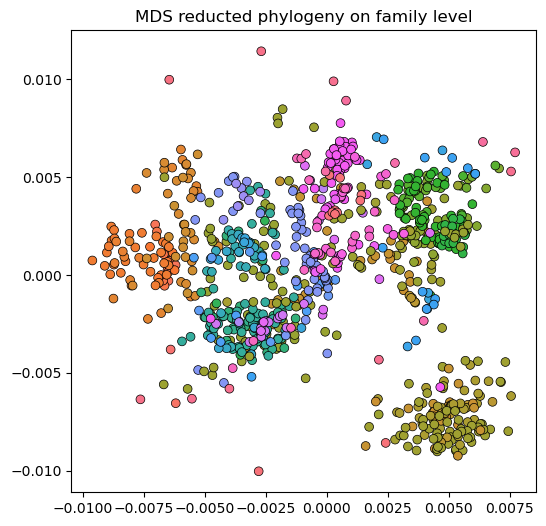

In [105]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = X_transformed[:, 0], y=X_transformed[:, 1], hue = mds_df['family'].values, legend=False, s=40, edgecolor='k')
plt.title("MDS reducted phylogeny on family level")

# Isomap

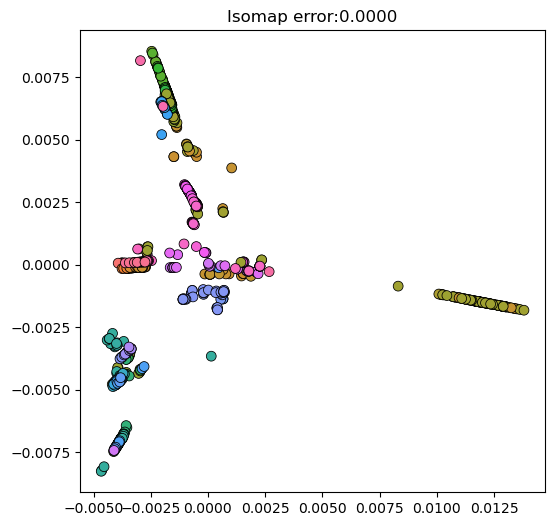

In [106]:
# Perform Isomap
from sklearn.manifold import Isomap

N=200
isomap = Isomap(n_components=3, metric='precomputed', n_neighbors=N)
model = isomap.fit(dm)
coords = model.transform(dm)

plt.figure(figsize = (6, 6))
sns.scatterplot(x=coords[:, 0], y=coords[:, 1], s=50, hue = mds_df['family'].values, legend=False, edgecolor='k')
plt.title(f'Isomap error:{model.reconstruction_error():.4f}')
plt.show()

# PCA

In [107]:
# Convert distance matrix to a positive semi-definite matrix
# Double centering
n = dm.shape[0]
H = np.eye(n) - np.ones((n, n)) / n
B = -0.5 * H @ (dm ** 2) @ H
eigenvalues, eigenvectors = np.linalg.eigh(B)
idx = np.argsort(-eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
eigenvalues = np.sqrt(np.maximum(eigenvalues, 0))  # Ensure non-negative eigenvalues

pca_coords = eigenvectors @ np.diag(eigenvalues)[:, :3]

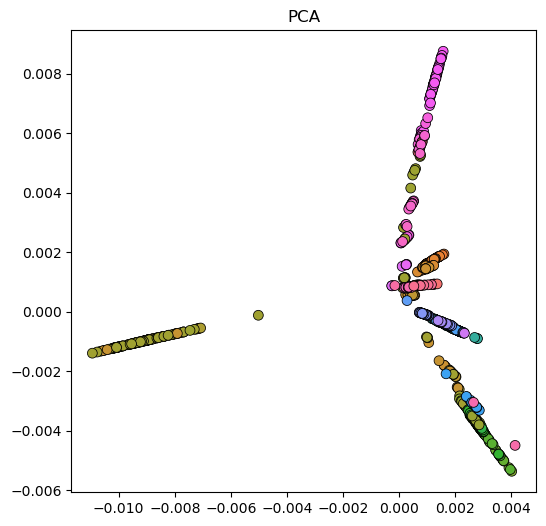

In [108]:
plt.figure(figsize = (6, 6))

sns.scatterplot(x=pca_coords[:, 0], y=pca_coords[:, 1], s=50, hue = mds_df['family'].values, legend=False, edgecolor='k')
plt.title(f'PCA')
plt.show()

## PROCRUSTES between unifrac matrix and abundance * phylogeny

In [16]:
def run_pcoa(df, distance = 'euclidean'):
    
    dm = squareform(pdist(df, distance))
    
    pcoa_fitted = pcoa(dm)
    variance_explained = pcoa_fitted.proportion_explained

    pcoa_samples = pcoa(dm).samples
    
    return variance_explained, pcoa_samples

def run_procrustes(pcoa1, pcoa2):

    Tmtx1, Tmtx2, Tdisp = procrustes(pcoa1, pcoa2)

    sns.scatterplot(x = Tmtx2[:, 0], y = Tmtx2[:, 1], label = 'true')
    sns.scatterplot(x = Tmtx1[:, 0], y = Tmtx1[:, 1], label = 'pred')
    plt.title(f'disparity{Tdisp:.4f}')
    plt.show()

In [109]:
small_taxonomy = taxonomy_relab.iloc[:200]

/home/zkarwowska/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.39287666143190464 and the largest is 16.37476343837164.
  warn(


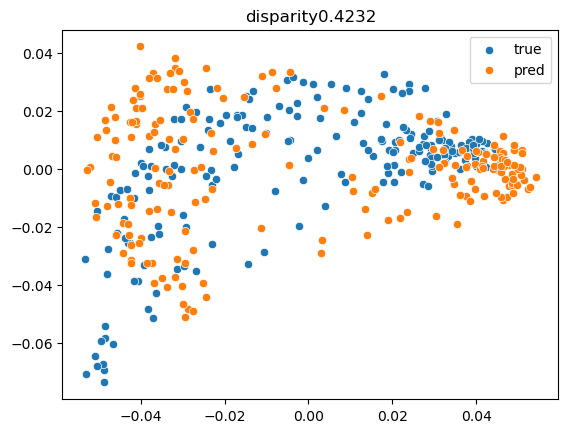

In [201]:
unifrac_pcoa_df = pcoa(weighted_unifrac_m).samples
var1, pcoa1 = run_pcoa(np.log(small_taxonomy+1e-2) * mds_df.E0.values); pcoa2 = unifrac_pcoa_df

run_procrustes(pcoa1, pcoa2)

/home/zkarwowska/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.39287666143190464 and the largest is 16.37476343837164.
  warn(


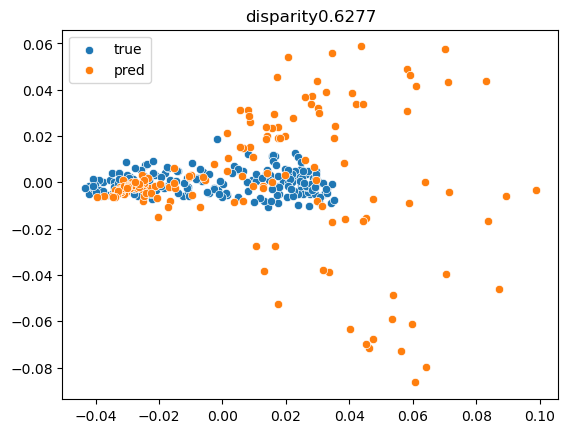

In [196]:
unifrac_pcoa_df = pcoa(weighted_unifrac_m).samples
var1, pcoa1 = run_pcoa(np.log(small_taxonomy+1e-2) * coords[:, 0]); pcoa2 = unifrac_pcoa_df

run_procrustes(pcoa1, pcoa2)

/home/zkarwowska/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.39287666143190464 and the largest is 16.37476343837164.
  warn(


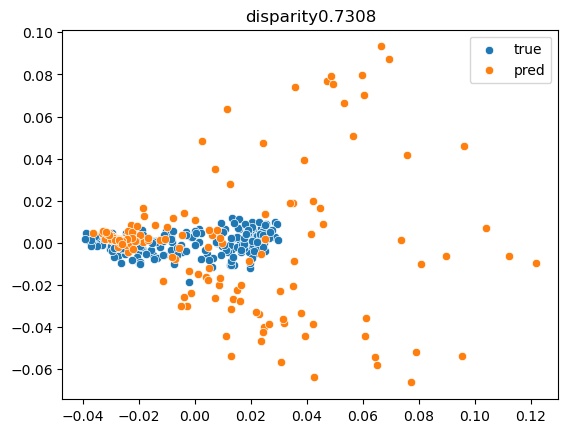

In [199]:
unifrac_pcoa_df = pcoa(weighted_unifrac_m).samples
var1, pcoa1 = run_pcoa(np.log(small_taxonomy+1e-2) * pca_coords[:, 0]); pcoa2 = unifrac_pcoa_df

run_procrustes(pcoa1, pcoa2)

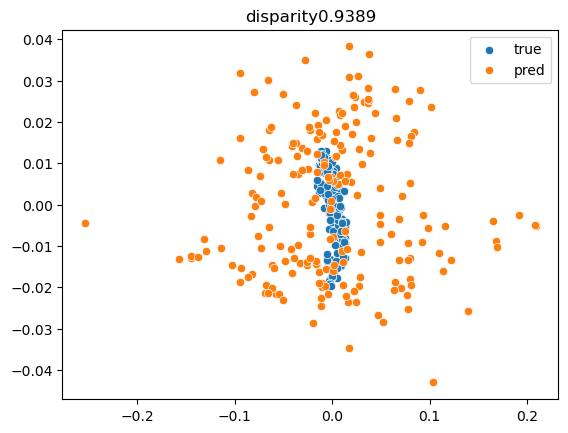

In [200]:
variance1, pcoa1 = run_pcoa(matrix_multiplication_results)
run_procrustes(pcoa1, unifrac_pcoa_df)

/home/zkarwowska/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.39287666143190464 and the largest is 16.37476343837164.
  warn(


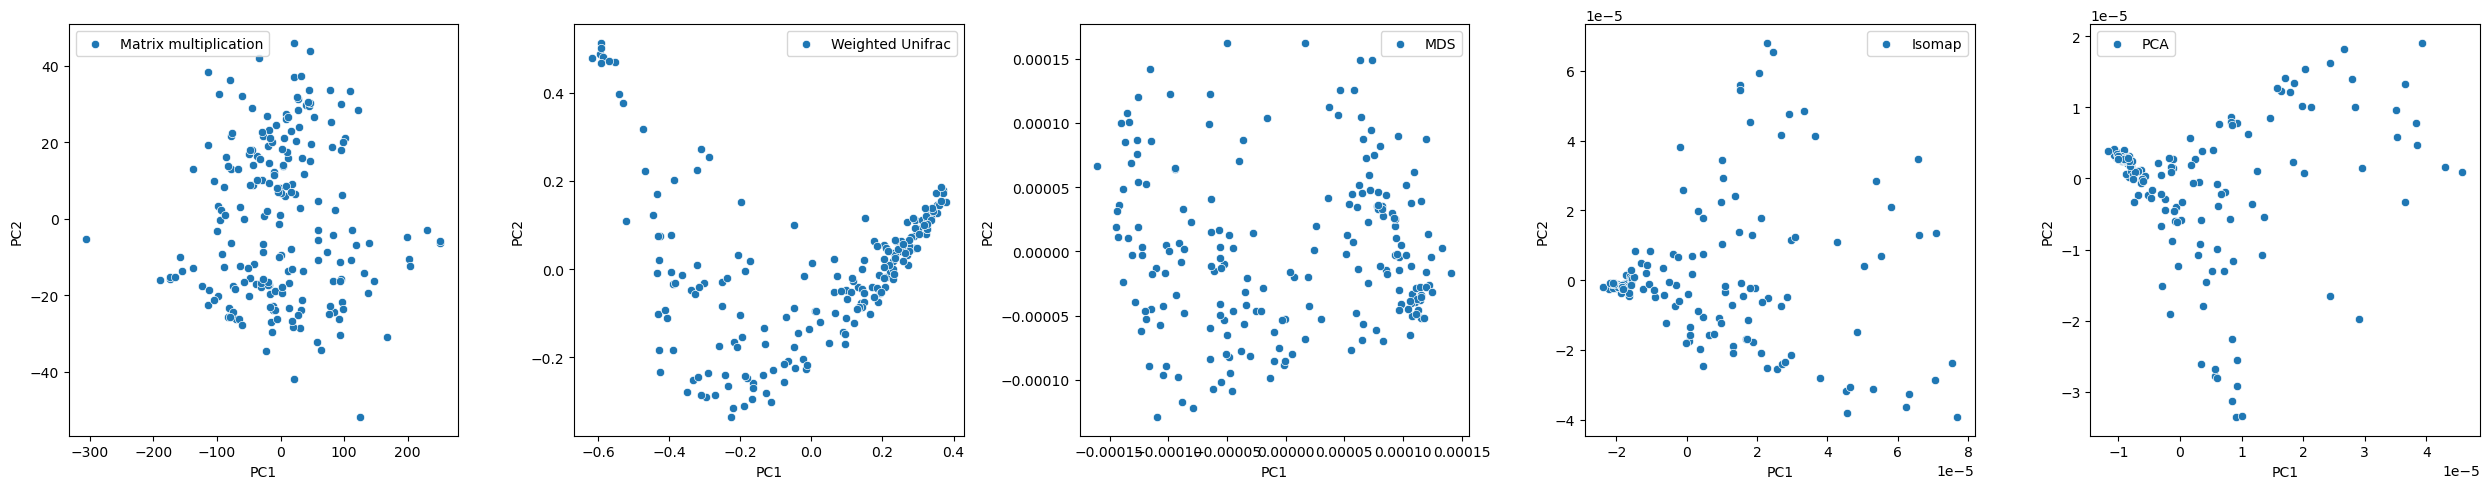

In [217]:
X_log = np.log(small_taxonomy+1e-2)

unifrac_var = pcoa(weighted_unifrac_m).proportion_explained
matumul_var, matmul_pcoa = run_pcoa(matrix_multiplication_results)
mds_var, mds_pcoa = run_pcoa(X_log * mds_df.E0.values * mds_df.E1.values)
isomap_var, isomap_pcoa = run_pcoa(X_log * coords[:, 0] * coords[:, 1])
pca_var, pca_pcoa = run_pcoa(X_log * pca_coords[:, 0] * pca_coords[:, 1])

fig, axes = plt.subplots(1, 5, figsize = (25, 5))

sns.scatterplot(x = matmul_pcoa.iloc[:, 0], y = matmul_pcoa.iloc[:, 1], label = 'Matrix multiplication', ax=axes[0])
sns.scatterplot(x = unifrac_pcoa_df.iloc[:, 0], y = unifrac_pcoa_df.iloc[:, 1], label = 'Weighted Unifrac', ax=axes[1])
sns.scatterplot(x = mds_pcoa.iloc[:, 0], y = mds_pcoa.iloc[:, 1], label = 'MDS', ax=axes[2])
sns.scatterplot(x = isomap_pcoa.iloc[:, 0], y = isomap_pcoa.iloc[:, 1], label = 'Isomap', ax=axes[3])
sns.scatterplot(x = pca_pcoa.iloc[:, 0], y = pca_pcoa.iloc[:, 1], label = 'PCA', ax=axes[4])

plt.tight_layout()

In [218]:
matumul_var[:2].sum(), mds_var[:2].sum(), isomap_var[:2].sum(), pca_var[:2].sum(), unifrac_var[:2].sum()

(0.9992951968666742,
 0.511229533870641,
 0.5022920351158916,
 0.79765319775486,
 0.5941495854506043)

In [224]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=5, random_state=0).fit(weighted_unifrac_m)
labels = kmedoids.labels_

/home/zkarwowska/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.39287666143190464 and the largest is 16.37476343837164.
  warn(


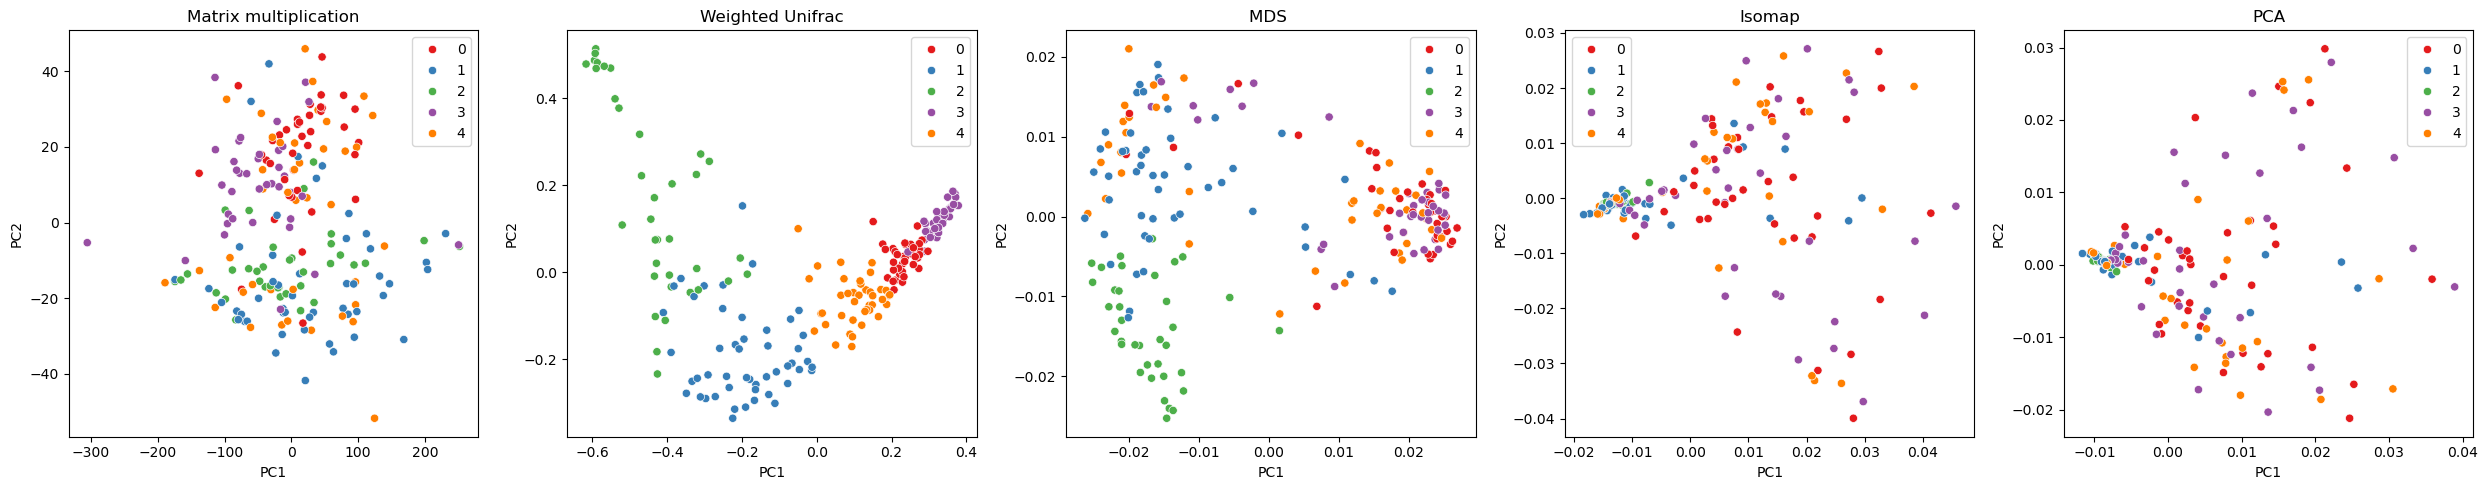

In [241]:
unifrac_var = pcoa(weighted_unifrac_m).proportion_explained
matumul_var, matmul_pcoa = run_pcoa(matrix_multiplication_results)
mds_var, mds_pcoa = run_pcoa(X_log * mds_df.E0.values )
isomap_var, isomap_pcoa = run_pcoa(X_log * coords[:, 0])
pca_var, pca_pcoa = run_pcoa(X_log * pca_coords[:, 0])


fig, axes = plt.subplots(1, 5, figsize = (25, 5))

sns.scatterplot(x = matmul_pcoa.iloc[:, 0], y = matmul_pcoa.iloc[:, 1], ax=axes[0], hue = labels, palette = 'Set1')
sns.scatterplot(x = unifrac_pcoa_df.iloc[:, 0], y = unifrac_pcoa_df.iloc[:, 1], ax=axes[1], hue = labels, palette = 'Set1')
sns.scatterplot(x = mds_pcoa.iloc[:, 0], y = mds_pcoa.iloc[:, 1], ax=axes[2], hue = labels, palette = 'Set1')
sns.scatterplot(x = isomap_pcoa.iloc[:, 0], y = isomap_pcoa.iloc[:, 1], ax=axes[3], hue = labels, palette = 'Set1')
sns.scatterplot(x = pca_pcoa.iloc[:, 0], y = pca_pcoa.iloc[:, 1], ax=axes[4], hue = labels, palette = 'Set1')

axes[0].title.set_text('Matrix multiplication')
axes[1].title.set_text('Weighted Unifrac')
axes[2].title.set_text('MDS ')
axes[3].title.set_text('Isomap')
axes[4].title.set_text('PCA')

plt.tight_layout()

In [242]:
matumul_var[:2].sum(),  unifrac_var[:2].sum(), mds_var[:2].sum(), isomap_var[:2].sum(), pca_var[:2].sum()

(0.9992951968666742,
 0.3577515225631477,
 0.3476511569318693,
 0.3878748137664392,
 0.5941495854506043)

/home/zkarwowska/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.39287666143190464 and the largest is 16.37476343837164.
  warn(


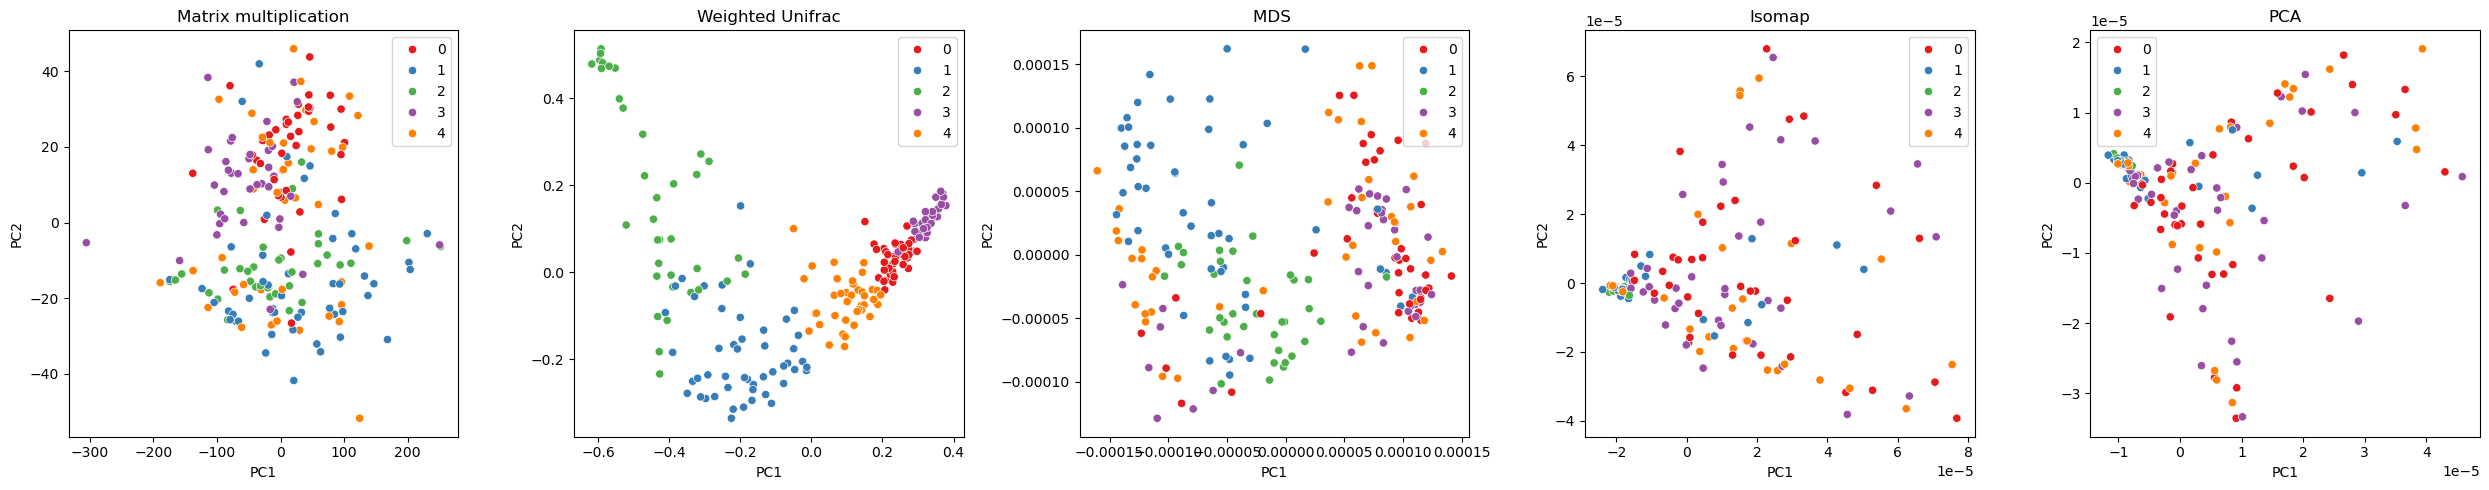

In [243]:
unifrac_var = pcoa(weighted_unifrac_m).proportion_explained
matumul_var, matmul_pcoa = run_pcoa(matrix_multiplication_results)
mds_var, mds_pcoa = run_pcoa(X_log * mds_df.E0.values * mds_df.E1.values)
isomap_var, isomap_pcoa = run_pcoa(X_log * coords[:, 0] * coords[:, 1])
pca_var, pca_pcoa = run_pcoa(X_log * pca_coords[:, 0] * pca_coords[:, 1])

fig, axes = plt.subplots(1, 5, figsize = (25, 5))

sns.scatterplot(x = matmul_pcoa.iloc[:, 0], y = matmul_pcoa.iloc[:, 1], ax=axes[0], hue = labels, palette = 'Set1')
sns.scatterplot(x = unifrac_pcoa_df.iloc[:, 0], y = unifrac_pcoa_df.iloc[:, 1], ax=axes[1], hue = labels, palette = 'Set1')
sns.scatterplot(x = mds_pcoa.iloc[:, 0], y = mds_pcoa.iloc[:, 1], ax=axes[2], hue = labels, palette = 'Set1')
sns.scatterplot(x = isomap_pcoa.iloc[:, 0], y = isomap_pcoa.iloc[:, 1], ax=axes[3], hue = labels, palette = 'Set1')
sns.scatterplot(x = pca_pcoa.iloc[:, 0], y = pca_pcoa.iloc[:, 1], ax=axes[4], hue = labels, palette = 'Set1')

axes[0].title.set_text('Matrix multiplication')
axes[1].title.set_text('Weighted Unifrac')
axes[2].title.set_text('MDS ')
axes[3].title.set_text('Isomap')
axes[4].title.set_text('PCA')

plt.tight_layout()

In [245]:
matumul_var[:2].sum(),  unifrac_var[:2].sum(), mds_var[:2].sum(), isomap_var[:2].sum(), pca_var[:2].sum()

(0.9992951968666742,
 0.5941495854506043,
 0.511229533870641,
 0.5022920351158916,
 0.79765319775486)